![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier


from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [5]:
# Celda 1
# Definición de parámetros y criterios de parada
max_depth = 6
num_pct = 10
max_features = None
min_gain=0.001

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [6]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

Accuracy para modelo con profundidad de 5 es de: 0.8879907621247113


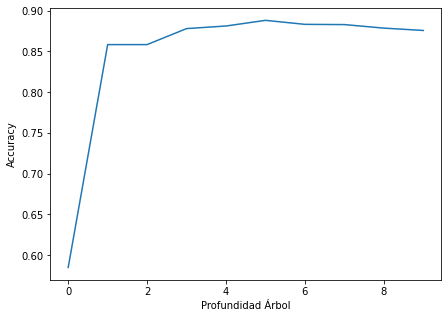

In [7]:



# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
profundidad_range = range(10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
tree_accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for profundidad in profundidad_range:
    tree=tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=profundidad, num_pct=10)
    # Ejecución de función tree_predict
    predicion_arbol=tree_predict(X_test, tree)
    tree_accuracy_scores.append(accuracy_score(y_test, predicion_arbol))

plt.figure(figsize=(7,5))
plt.plot(profundidad_range, tree_accuracy_scores)
plt.xlabel('Profundidad Árbol')
plt.ylabel('Accuracy')

max_value = max(tree_accuracy_scores)
td_acc=max_value
max_index = tree_accuracy_scores.index(max_value)
print('Accuracy para modelo con profundidad de', profundidad_range[max_index], 'es de:',max_value)

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [40]:
# Celda 2
# Creación de 10 muestras de bootstrap 
np.random.seed(100)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# Visualización muestra boostrap #1 para entremiento
X_train.iloc[samples[0], :]

# Tree classifier
treeclf=DecisionTreeClassifier(max_depth=None, random_state=6)
y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_i = X_train.iloc[sample, 0:]
    y_train_i = y_train.iloc[sample]
    treeclf.fit(X_train, y_train)
    y_pred.iloc[:,i] = treeclf.predict(X_test)
    
# Votación mayoritaria
y_pred_votacion_mayoritaria = (y_pred.sum(axis=1) >= (n_B / 2)).astype(np.int)
bagging_accuracy_scores=(accuracy_score(y_test, y_pred_votacion_mayoritaria))

# Creación de 100 muestras de bootstrap
n_estimators = 10
# Estimación de los errores OOB para cada clasificador
errors = np.zeros(n_estimators)
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors) / (1 - errors).sum()
# Ponderación de las predicciones con los pesos alpha
weighted_sum_1 = ((y_pred) * alpha).sum(axis=1)
# Desempeño al hacer votación ponderada
y_pred_ponderada = (weighted_sum_1 >= 0.5).astype(np.int)
bagging_accuracy_scores_p=(accuracy_score(y_test, y_pred_ponderada))

print('El Accuracy para el modelo Bagging manual con 10 árboles, votacion ponderada es de: \n', bagging_accuracy_scores_p)
print('El Accuracy para el modelo Bagging manual con 10 árboles, votacion mayoritaria es de: \n', bagging_accuracy_scores)

El Accuracy para el modelo Bagging manual con 10 árboles, votacion ponderada es de: 
 0.8432448036951501
El Accuracy para el modelo Bagging manual con 10 árboles, votacion mayoritaria es de: 
 0.8432448036951501


### Analísis
Entrenamos dos modelos de Bagging de 10 árboles de forma manual, uno para el método de votación ponderada y otro para el método de votación mayoritaria. El accuracy para los dos métodos fue de 0.8432448036951501.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [41]:
# Celda 3
# Uso de Baggingclfressor de la libreria (sklearn) donde se usa el modelo DecisionTreeRegressor como estimador
n_features=X_train.shape[1]
bagclf = BaggingClassifier(DecisionTreeClassifier(max_features="log2"), n_estimators=10, 
                          bootstrap=True, oob_score=True, random_state=42)
# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagclf.fit(X_train, y_train)
prediccionesbagging = bagclf.predict(X_test)

# Matriz de prediccion correspondiente a la prediccion en test
pred_matrix_bagging=confusion_matrix(y_true=y_test, y_pred=prediccionesbagging)
print('La matriz de predicciones para el arbol de decision es: \n')
print(pred_matrix_bagging)

# Precision: la precision de la prediccion test es:
precisionbclf=precision_score(y_true=y_test, y_pred=prediccionesbagging)
bag_acc=metrics.accuracy_score(prediccionesbagging, y_test)
print('Precision de la prediccion es: \n', precisionbclf)

# Metricas
print('F1_Score: \n', metrics.f1_score(prediccionesbagging, y_test), '\n Accuracy: \n',metrics.accuracy_score(prediccionesbagging, y_test))




La matriz de predicciones para el arbol de decision es: 

[[1185  253]
 [ 282 1744]]
Precision de la prediccion es: 
 0.8733099649474211
F1_Score: 
 0.8670146656723838 
 Accuracy: 
 0.8455542725173211


### Analísis

Entrenamos uno modelo Bagging con la librería sklearn utilizando max_features igual al logaritmo del número de predictores. El accuacy del model fue 0.8455542725173211.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [42]:
# Celda 4
clf_rf = RandomForestClassifier(random_state=0)
clf_rf.fit(X_train, y_train)

# Predicción
y_pred_RF=clf_rf.predict(X_test)

# Cálculo del Accuracy
acc_rf =  (accuracy_score(y_test, y_pred_RF))
print('El Accuracy para el modelo Random Forest es de:', acc_rf)

El Accuracy para el modelo Random Forest es de: 0.8443995381062356


In [43]:
feature_cols=X_train.columns
desp_rf_clf=pd.DataFrame({'feature':feature_cols, 'importance':clf_rf.feature_importances_}).sort_values('importance', ascending=False)
desp_rf_clf

,feature,importance
1,Mileage,0.647270
0,Year,0.245373
3,M_Camry4dr,0.053479
7,M_CamrySE,0.021141
8,M_CamryXLE,0.011228
6,M_CamryLE,0.009429
2,M_Camry,0.005997
5,M_CamryL,0.003618
4,M_CamryBase,0.002464


#### Análisis

Se ajusta el modelo _Random Forest_ con los datos de entrenamiento utilizando la función _RandomForestClassifier_ sin incluir ningún parámetro de calibración. Como resultado, se obtiene un _Accuracy_ de 0.84439 sobre los datos de evaluación. Las variables más relevantes son _Mileage_ (millas recorridas), _Year_ (Modelo) y _M_Camry4dr_ (Modelo Camry 4dr).

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

Accuracy para modelo con n_estimator de 11 es de: 0.8439256788947118


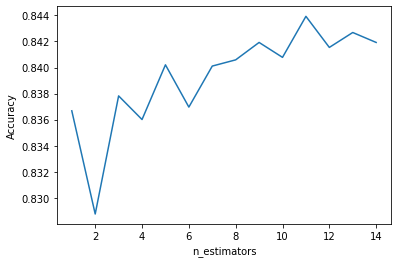

In [44]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(1,15)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())
    

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

max_value = max(accuracy_scores)
max_index = accuracy_scores.index(max_value)
print('Accuracy para modelo con n_estimator de', estimator_range[max_index], 'es de:',max_value)

Accuracy para modelo con max_features de 9 es de: 0.850976655550262


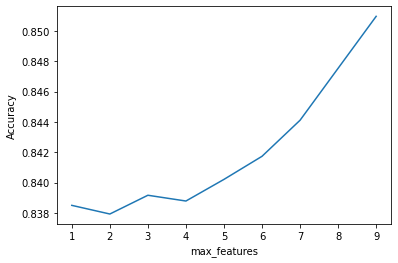

In [45]:
feature_cols=X_train.columns

# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(feature_cols)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestClassifier(max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())
    
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

max_value = max(accuracy_scores)
max_index = accuracy_scores.index(max_value)
print('Accuracy para modelo con max_features de', feature_range[max_index], 'es de:',max_value)

Accuracy para modelo con profundidad de 6 es de: 0.8845165917654002


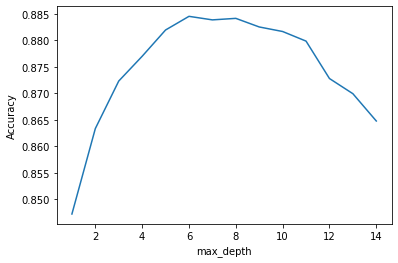

In [46]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
depth_range = range(1,15)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for depth in estimator_range:
    clf = RandomForestClassifier(max_depth=depth, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())
    

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

max_value = max(accuracy_scores)
max_index = accuracy_scores.index(max_value)
print('Accuracy para modelo con profundidad de', depth_range[max_index], 'es de:',max_value)

Accuracy para modelo con n_estimators de 14 es de: 0.8900115473441108


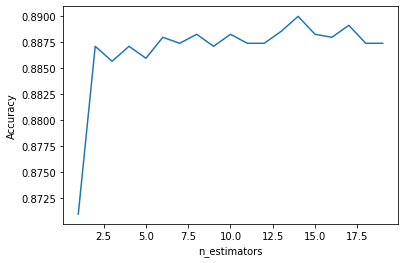

In [47]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(1,20)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf_rf_calibrado = RandomForestClassifier(n_estimators=estimator, max_features=9,max_depth=6, random_state=0, n_jobs=-1)
    clf_rf_calibrado.fit(X_train, y_train)
    y_pred_RF_calibrado=clf_rf_calibrado.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred_RF_calibrado))
    

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

max_value = max(accuracy_scores)
max_index = accuracy_scores.index(max_value)
print('Accuracy para modelo con n_estimators de', estimator_range[max_index], 'es de:',max_value)

In [48]:
clf_rf_calibrado = RandomForestClassifier(n_estimators=14,max_features=9,max_depth=6, random_state=0, n_jobs=-1)
clf_rf_calibrado.fit(X_train, y_train)

# Predicción
y_pred_RF_calibrado=clf_rf_calibrado.predict(X_test)

# Cálculo del Accuracy
acc_rf_cal =  (accuracy_score(y_test, y_pred_RF_calibrado))
print('El Accuracy para el modelo Random Forest es de:', acc_rf_cal)

El Accuracy para el modelo Random Forest es de: 0.8900115473441108


In [49]:
desp_rf_clf_cal=pd.DataFrame({'feature':feature_cols, 'importance':clf_rf_calibrado.feature_importances_}).sort_values('importance', ascending=False)
desp_rf_clf_cal


,feature,importance
1,Mileage,0.666197
0,Year,0.296190
6,M_CamryLE,0.019110
8,M_CamryXLE,0.009113
2,M_Camry,0.007537
5,M_CamryL,0.001266
7,M_CamrySE,0.000541
3,M_Camry4dr,0.000046
4,M_CamryBase,0.000000


#### Procedimiento de calibración del modelo

El procedimiento que arrojó el mejor valor de _Accuracy_ es el siguiente:

1. **n_estimator**: inicialmente se define un rango amplio búsqueda entre 10 y 200 estimadores (con pasos intermedios de 10) donde se identifica que el mejor valor de _Accuracy_ se encuentra en el intervalo de valores menor a 40. Luego se hace una búsqueda detallada con un rango más estrecho (con pasos intermedios de 1) donde se encuentra que el mayor valor de _Accuracy_ está asociado a 11 estimadores.
2. **max_features**: sin tener en cuenta el mejor valor obtenido para n_estimator en el paso anterior, se evalúa el _Accuracy_ para el rango de 1 a 9 variables. Se encuentra que el mayor resultado de _Accuracy_ está asociado a 9 variables, es decir, todas las variables de entrada.
3. **max_depth**: sin tener en cuenta los mejores valores obtenidos en los pasos anteriores, se evalúa el _Accuracy_ para un rango de máxima profundidad entre 1 y 14. Se encuentra que el mayor resultado de _Accuracy_ está asociado a una máxima profundidad de 6.
4. Luego, se evalúa el modelo con los parámetros de calibración obtenidos en los pasos anteriores (n_estimator = 11, max_features = 9, max_depth = 6) y se obtiene _Accuracy_ de 0.88827. A su vez, las variables más relevantes son Mileage (millas recorridas) y Year (Modelo).
5. Por úlitmo, se itera de nuevo **n_estimators** con los valores de los demás parámetros obtenidos en el punto anterior obteniendo así un mejor valor de _Accuracy_ (0.8900) para los siguientes parámetros de calibración: n_estimators=14, max_features=9 y max_depth=6.

#### Análisis

- El _Accuracy_ del modelo calibrado es 0.8900 mientras que el _Accuracy_ del modelo sin calibrar es 0.8418. Esto indica que el resultado mejoró en 0.0482.
- Ambos modelos coinciden en que las variables más relevantes son Mileage (millas recorridas) y Year (Modelo). En el modelo calibrado, estas varibles tienen más importancia (0.96) que en el modelo sin calibrar (0.85).
- En otros procedimientos de calibración que se probaron, se obtuvo un _Accuracy_ ligeramente menor. En estos procedimientos se realizó la calibración secuencial de cada parámetro, es decir que se incluyó el mejor resultado del primer parámetro calibrado para hacer la calibración del segundo parámetro, y así sucesivamente.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [18]:
# Celda 6
xgb_clf = XGBClassifier()
# Entrenamiento (fit) y desempeño del modelo XGBClassifier
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

# Cálculo del Accuracy
acc_xgb = (accuracy_score(y_test, y_pred_xgb))
print('El Accuracy para el modelo XGBoost calibrado es de:', acc_xgb)

El Accuracy para el modelo XGBoost calibrado es de: 0.8856812933025404


In [19]:
# Impresión de resultados de desemepeño del modelo
desp_xgb_clf=pd.DataFrame({'feature':feature_cols, 'importance':xgb_clf.feature_importances_}).sort_values('importance', ascending=False)
desp_xgb_clf

,feature,importance
0,Year,0.469196
1,Mileage,0.147454
6,M_CamryLE,0.101129
8,M_CamryXLE,0.088409
2,M_Camry,0.074973
5,M_CamryL,0.066302
3,M_Camry4dr,0.027128
7,M_CamrySE,0.025409
4,M_CamryBase,0.000000


#### Comentarios

Por definicion desde su construccion, el algoritmo XGBoost es un ensamble de arboles de decision que usa diferentes tecnicas para mayor velocidad de entrenamiento y mejor desempeno.Se nota en el resultado del Accuracy que el ensamblaje de arboles de decision construidos secuencialmente con mejoras algoritmicas y optimizacion de sistemas para ejecucion, donde se puede ver que sin parametros supera a los algoritmos como bagging y random forest sin parametros, ubicandose muy cerca del desempeno de los arboles de decision.

Por otro lado, uno de los puntos fuertes en el algoritmo XGboost, son sus parametros, por lo que no definirlos, implica desaprovechar las bondades del algoritmo, y teniendo este un comportamiento inferior a otro algoritmos. En este ejercicio podemos notarlo.

Finalmente, la importancia de las caracteristicas del set de datos resalta notablemente el tiempo, siendo mas del doble de importante esta caracteristica con respecto a las demas, aunque el algoritmo por no usar parametros no esta optimizado para la flexibilidad y sobreajuste.


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

##### Calibracion de parametros de manera individual

Accuracy para modelo con profundidad de 0.1 es de: 0.8792524731669469


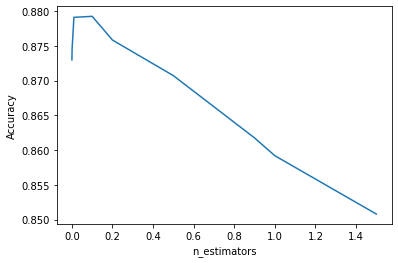

In [20]:
# Celda 7
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
learning_rate_range = [0.0001,0.001,0.01,0.1,0.2,0.5,0.9,1,1.5]

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for lr in learning_rate_range:
    xgb_clf = XGBClassifier(learning_rate=lr)
    accuracy_scores.append(cross_val_score(xgb_clf,X_train, y_train, cv=10, scoring='accuracy').mean())
    

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(learning_rate_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

max_value = max(accuracy_scores)
max_index = accuracy_scores.index(max_value)
print('Accuracy para modelo con profundidad de', learning_rate_range[max_index], 'es de:',max_value)

Accuracy para modelo con profundidad de 1 es de: 0.8795367661321608


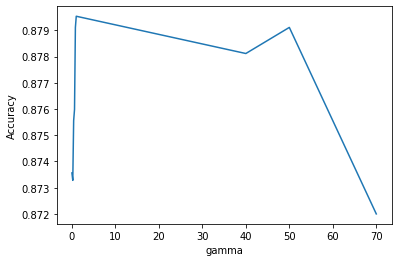

In [21]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
gamma_range = [0.001, 0.2,  0.4,  0.6,  0.8, 1,40,50,70]

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for g in gamma_range:
    xgb_clf = XGBClassifier(gamma=g)
    accuracy_scores.append(cross_val_score(xgb_clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(gamma_range, accuracy_scores)
plt.xlabel('gamma')
plt.ylabel('Accuracy')

max_value = max(accuracy_scores)
max_index = accuracy_scores.index(max_value)
print('Accuracy para modelo con profundidad de', gamma_range[max_index], 'es de:',max_value)

Accuracy para modelo con profundidad de 0.4 es de: 0.8812431300918144


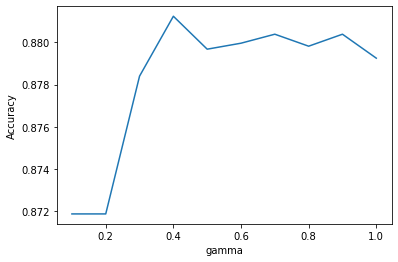

In [22]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for e in estimator_range:
    xgb_clf = XGBClassifier(learning_rate=0.1,colsample_bytree=e)
    accuracy_scores.append(cross_val_score(xgb_clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('gamma')
plt.ylabel('Accuracy')

max_value = max(accuracy_scores)
max_index = accuracy_scores.index(max_value)
print('Accuracy para modelo con profundidad de', estimator_range[max_index], 'es de:',max_value)

##### Calibracion de parametros de manera grupal

In [23]:
# Utilizando el valor de los parametros calibrados individualmente

xgb_clf_cal = XGBClassifier(learning_rate=0.1,gamma=1,colsample_bytree=0.4)
# Entrenamiento (fit) y desempeño del modelo XGBClassifier
xgb_clf_cal.fit(X_train, y_train)
y_pred_xgb_cal = xgb_clf_cal.predict(X_test)
# metrics.f1_score(y_pred_xgb, y_test.values), metrics.accuracy_score(y_pred_xgb, y_test.values)

# Cálculo del Accuracy
acc_XGB_cal = (accuracy_score(y_test, y_pred_xgb_cal))
print('El Accuracy para el modelo XGBoost calibrado es de:', acc_XGB_cal)

El Accuracy para el modelo XGBoost calibrado es de: 0.8874133949191686


El mejor parametro es de para colsample_bytree es: 0.5 
El Accuracy para el modelo XGBoost calibrado es de: 0.8894341801385681


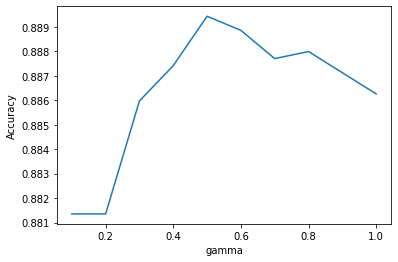

In [24]:
# calibrando Solo el parametro colsample_bytree, y dejando los valores obtenidos para learning_rate, gamma

# Entrenamiento (fit) y desempeño del modelo XGBClassifier



estimator_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for e in estimator_range:
    xgb_clf_cal = XGBClassifier(learning_rate=0.1,gamma=1,colsample_bytree=e)
    xgb_clf_cal.fit(X_train, y_train)
    y_pred_xgb_cal = xgb_clf_cal.predict(X_test)
    accuracy_scores.append((accuracy_score(y_test, y_pred_xgb_cal)))
    

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('gamma')
plt.ylabel('Accuracy')

max_value = max(accuracy_scores)
max_index = accuracy_scores.index(max_value)
print('El mejor parametro es de para colsample_bytree es:', estimator_range[max_index], '\nEl Accuracy para el modelo XGBoost calibrado es de:',max_value)



El mejor parametro es de para gamma es: 0.2 
El Accuracy para el modelo XGBoost calibrado es de: 0.8897228637413395


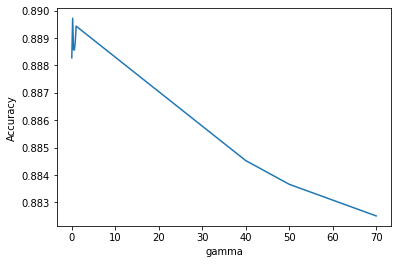

In [25]:
# calibrando Solo el parametro gamma y dejando los valores obtenidos para learning_rate, colsample_bytree

# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
gamma_range = [0.001, 0.2,  0.4,  0.6,  0.8, 1,40,50,70]

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for g in gamma_range:
    xgb_clf_cal = XGBClassifier(learning_rate=0.1,gamma=g,colsample_bytree=0.5)
    xgb_clf_cal.fit(X_train, y_train)
    y_pred_xgb_cal = xgb_clf_cal.predict(X_test)
    accuracy_scores.append((accuracy_score(y_test, y_pred_xgb_cal)))
    

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(gamma_range, accuracy_scores)
plt.xlabel('gamma')
plt.ylabel('Accuracy')

max_value = max(accuracy_scores)
max_index = accuracy_scores.index(max_value)
print('El mejor parametro es de para gamma es:', gamma_range[max_index], '\nEl Accuracy para el modelo XGBoost calibrado es de:',max_value)


El mejor parametro es de para gamma es: 30 
El Accuracy para el modelo XGBoost calibrado es de: 0.8914549653579676


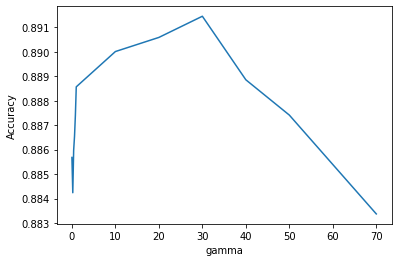

In [26]:
#Despues se realizaron iteraciones de los parametros learning_rate y colsample_bytree a la vez, 
# luego de llegar al mejor valor de esos dos parametros, se comenzo nuevamente la iteracion de gamma



# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
gamma_range = [0.001, 0.2,  0.4,  0.6,  0.8, 1,10,20,30,40,50,70]

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for g in gamma_range:
    xgb_clf_cal = XGBClassifier(learning_rate=0.3,gamma=g,colsample_bytree=0.7)
    xgb_clf_cal.fit(X_train, y_train)
    y_pred_xgb_cal = xgb_clf_cal.predict(X_test)
    accuracy_scores.append((accuracy_score(y_test, y_pred_xgb_cal)))
    

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(gamma_range, accuracy_scores)
plt.xlabel('gamma')
plt.ylabel('Accuracy')

max_value = max(accuracy_scores)
max_index = accuracy_scores.index(max_value)
print('El mejor parametro es de para gamma es:', gamma_range[max_index], '\nEl Accuracy para el modelo XGBoost calibrado es de:',max_value)


In [27]:
#xgb_clf_cal = XGBClassifier(learning_rate=0.3,gamma=20,colsample_bytree=0.7)
xgb_clf_cal = XGBClassifier(learning_rate=0.3,gamma=30,colsample_bytree=0.7)
# Entrenamiento (fit) y desempeño del modelo XGBClassifier
xgb_clf_cal.fit(X_train, y_train)
y_pred_xgb_cal = xgb_clf_cal.predict(X_test)
# metrics.f1_score(y_pred_xgb, y_test.values), metrics.accuracy_score(y_pred_xgb, y_test.values)

# Cálculo del Accuracy
acc_XGB_cal = (accuracy_score(y_test, y_pred_xgb_cal))
print('El Accuracy para el modelo XGBoost calibrado es de:', acc_XGB_cal)

El Accuracy para el modelo XGBoost calibrado es de: 0.8914549653579676


In [28]:
# Impresión de resultados de desemepeño del modelo
desp_xgb_clf_cal=pd.DataFrame({'feature':feature_cols, 'importance':xgb_clf_cal.feature_importances_}).sort_values('importance', ascending=False)
desp_xgb_clf_cal

,feature,importance
1,Mileage,0.472876
0,Year,0.272112
3,M_Camry4dr,0.110480
6,M_CamryLE,0.054892
8,M_CamryXLE,0.046704
2,M_Camry,0.042935
4,M_CamryBase,0.000000
5,M_CamryL,0.000000
7,M_CamrySE,0.000000


##### Comentarios
El algoritmo XGBoost tiene 3 tipos de parametros: parametros generales, parametros de refuerzo y parametros de tareas.

En este ejercicio se propone calibrar y usar los parametros: learning rate, gamma y colsample_bytree, los cuales hacen parte de los parametros de refuerzo, en este caso resuezo de arboles (Tree Booster), a continuacion se tiene una breve descripcion de cada uno de los parametros mencionados:

learning rate: La reducción del tamaño del paso se utiliza en la actualización para evitar el sobreajuste. Después de cada paso de refuerzo, podemos obtener directamente los pesos de las nuevas características, y el learning rate reduce los pesos de las características para que el proceso de refuerzo sea más conservador. Su rango esta entre [0,1]

gamma: Reducción mínima de pérdidas necesaria para realizar una nueva partición en un nodo hoja del árbol. Cuanto mayor sea gamma, más conservador será el algoritmo. su rango esta entre [0,inf]

colsample_bytree: es la proporción de submuestreo de columnas al construir cada árbol. El submuestreo se realiza una vez por cada árbol construido.

De acuerdo con la definicion anterior, y con el fin de contrastar en la practica el comportamiento de cada uno de los parametros y su influencia en el resultado del algoritmo, se procedio de la siguiente manera:

1. Se calibraron los parametros por separado para observar su influencia en el resultado final.
2. Luego, se unieron los tres parametros con sus resultados para observar el resultado final, 0.8874133949191686
3. Luego, con los tres parametros juntos, se itero sobre el parametro colsample_bytree = 0.5, y un accuracy de 0.8894341801385681 obteniendo una mejora con el resultado anterior.
4. Luego, se itero sobre el parametro gamma con el fin de reducir las perdidas en las nuevas particiones de arboles, obteniendo un gamma = 0.2 y un accuracy de 0.8897228637413395, encontrandose una leve mejoria con respecto al resultado anterior.
5. Finalmente, con el fin de seguir experimentando con los parametros y obtener el mejor accuracy posible, se decidio iterar nuevamente en colsample_bytree = 0.7 y seguido en gamma, obteniendo el mejor comportamiento con un gamma=30 y un accuracy =0.8914549653579676

Nota: para las iteraciones iniciales se uso el set de datos X_train, y_train, ya que no se evidencio diferencia con usar los set de datos mas grandes en este caso X y y.

Con la optimizacion de parametros se encontro que la importancia de las caracteristicas cambio con respecto a el agoritmo sin parametros, siendo para este resultado la caracteristica mas importante Mileage con 0.47 seguido por Year con 0.27, lo que evidencia la influencia de los parametros en el sobreajuste de la muestra asi como en la rediccion minima de perdidas en las nuevas particiones, notando asi que el aspecto mas importante del XGBoost son sus variables y la correcta combinacion de estas.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [29]:
# Celda 8


print(f"\nUsando Random Forest sin variables\n{desp_rf_clf}\n")
print(f"\nUsando Random Forest con los parámetros max_depth, max_features y n_estimators, calibrados\n{desp_rf_clf_cal}\n")
print(f"\nUsando XGBoost sin variables\n {desp_xgb_clf}\n")
print(f"\nUsando XGBoost con los parámetros learning rate, gamma y colsample_bytree, calibrados\n{desp_xgb_clf_cal}\n")


Usando Random Forest sin variables
       feature  importance
1      Mileage    0.611990
0         Year    0.246934
3   M_Camry4dr    0.077561
7    M_CamrySE    0.037222
6    M_CamryLE    0.008447
8   M_CamryXLE    0.008265
2      M_Camry    0.004129
5     M_CamryL    0.003582
4  M_CamryBase    0.001870


Usando Random Forest con los parámetros max_depth, max_features y n_estimators, calibrados
       feature  importance
1      Mileage    0.666197
0         Year    0.296190
6    M_CamryLE    0.019110
8   M_CamryXLE    0.009113
2      M_Camry    0.007537
5     M_CamryL    0.001266
7    M_CamrySE    0.000541
3   M_Camry4dr    0.000046
4  M_CamryBase    0.000000


Usando XGBoost sin variables
        feature  importance
0         Year    0.469196
1      Mileage    0.147454
6    M_CamryLE    0.101129
8   M_CamryXLE    0.088409
2      M_Camry    0.074973
5     M_CamryL    0.066302
3   M_Camry4dr    0.027128
7    M_CamrySE    0.025409
4  M_CamryBase    0.000000


Usando XGBoost con los pará

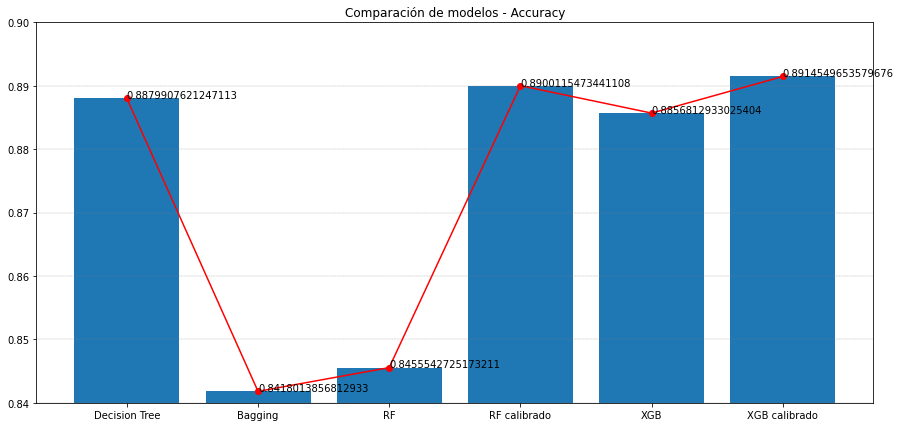

In [34]:

# Comparación de todos los resultados

fig = plt.figure(figsize=(15,7))
ax1=plt.subplot(1,1,1)
ax1.set_ylim(0.84,0.9)
ax1.grid(axis='y',color='gray', linestyle='--', linewidth=0.3)

ejeX = ['Decision Tree','Bagging','RF','RF calibrado', 'XGB','XGB calibrado']
ejeY = [td_acc,acc_rf,bag_acc, acc_rf_cal , acc_xgb, acc_XGB_cal]
plt.bar(ejeX,ejeY)
ax1.plot(ejeX,ejeY,marker='o', color= 'red')
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)

plt.title("Comparación de modelos - Accuracy")
plt.show()


### Comparación de los modelos Random Forest y XGBoost

Utilizando el Accuracy para medir el desempeño de los modelos obtenemos que:
- El modelo Random Forest sin calibrar dio como resultado un Accuracy de **0.84439**
- El modelo Random Forest calibrado con los parámetros n_estimators=14,max_features=9,max_depth=6, random_state=0, n_jobs=-1 arrojó un *Accuracy* de **0.89001**
- El modelo XGBoost son calibrar dio como resultado un Accuracy de **0.88568**
- El modelo XGBoost calibrado con los parámetros learning_rate=0.3,gamma=30,colsample_bytree=0.7 arrojó un accuracy de **0. 89145**

Por otro lado, al comparar la importancia de las variables se obtiene que:
- El modelo Random Forest las variables Mileage y Year tienen una importancia conjunta del 0.858
- El modelo Random Forest calibrado estas mismas variables tienen una importancia conjunta del 0.896 y la tercera variable importancia solo tiene un valor de 0.019, lo que muestra la concentración del modelo.
- Para el modelo XGBoost las variables Mileage y Year tienen una importancia conjunta del 0.616, a pesar de verse una distribución mayor de la importancia de las variables, como se mencionó anteriormente este algoritmo no está optimizado para la flexibilidad y el sobreajuste.
- El modelo XGBoost calibrado estas mismas variables tienen una importancia conjunta del 0.744, pero al contrario del anterior, si tiene parámetros que mejoran el sobreajuste y la flexibilidad del modelo.


Según los resultados **el mejor modelo para la predicción es el XGBoost calibrado**, este modelo presenta ventajas debido principalmente a la calibración de sus parámetros, lo veremos a continuación:
1.	El parámetro learning rate regula qué tan rápido aprende el modelo, mejorando uno de los principales problemas del Gradient Boosting, el sobreajuste. 
2.	El parámetro gamma por su parte ayuda a la interpretabilidad del modelo, ya que, a un número mayor de gamma, el modelo es más conservador.
Además, la técnica XGBoost:
3.	Presenta mejoras en el rendimiento computacional
4.	Puede manejar grandes bases de datos y valores nulos o perdidos

Según los resultados **el modelo con el peor desempeño es el Random Forest sin calibrar**, el modelo presenta las siguientes desventajas:
1.	Son modelos difíciles de interpretar y se pierde el control sobre lo que realiza el modelo (se asemejan a modelos de caja negra)
2.	Este en particular no posee ninguna calibración de parámetros, por lo que puede estar consumiendo recursos computacionales no necesarios, por ejemplo, realizando la máxima profundidad de los árboles cuando el aporte no es significativo o utilizando el total de variables de entrada del modelo.
